# Data Import

In [14]:
# Import Dependencies 
import findspark
findspark.init()
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from pyspark.sql.functions import col


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

24/03/18 12:14:05 WARN Utils: Your hostname, Home-iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.3 instead (on interface en1)
24/03/18 12:14:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/18 12:14:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in the CSV into a DataFrame.
from pyspark import SparkFiles
path = "../data/ratings.csv"

spark.sparkContext.addFile(path)
df = spark.read.csv(SparkFiles.get("ratings.csv"), sep=",", header=True)
df.show()

+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+------------------------+-----------------+------------+----------------+-----------+-------------+---------------------+-----------------+--------------+----------------------+-------------------------+----------------------+--------------------------+-----------------------------+------------------------+
|       Rating Agency|         Corporation|Rating|Rating Date|    CIK|Binary Rating|SIC Code|Sector|Ticker|Current Ratio|Long-term Debt / Capital|Debt/Equity Ratio|Gross Margin|Operating Margin|EBIT Margin|EBITDA Margin|Pre-Tax Profit Margin|Net Profit Margin|Asset Turnover|ROE - Return On Equity|Return On Tangible Equity|ROA - Return On Assets|ROI - Return On Investment|Operating Cash Flow Per Share|Free Cash Flow Per Share|
+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+-------------------

In [4]:
# Create a temporary view of the DataFrame.
df.createOrReplaceTempView('ratings')

## Explore the data

In [5]:
# Explore the data
query = """
SELECT YEAR(`Rating Date`) as YEAR, Rating, COUNT(Rating)
FROM ratings
GROUP BY YEAR(`Rating Date`), Rating
ORDER BY YEAR(`Rating Date`), COUNT(Rating) DESC;
"""
spark.sql(query).show(500)

+----+------+-------------+
|YEAR|Rating|count(Rating)|
+----+------+-------------+
|2010|  BBB+|            6|
|2010|   BBB|            5|
|2010|    A-|            5|
|2010|  BBB-|            5|
|2010|     A|            5|
|2010|   AAA|            3|
|2010|   BB+|            3|
|2010|   BB-|            3|
|2010|    B+|            2|
|2010|    BB|            2|
|2010|   AA-|            1|
|2010|     B|            1|
|2011|   BBB|           41|
|2011|     A|           40|
|2011|  BBB-|           36|
|2011|  BBB+|           36|
|2011|   BB-|           23|
|2011|     B|           23|
|2011|    A-|           22|
|2011|   BB+|           22|
|2011|    BB|           16|
|2011|    A+|           10|
|2011|    AA|           10|
|2011|   AAA|           10|
|2011|  CCC+|            9|
|2011|    B+|            9|
|2011|    B-|            6|
|2011|   CCC|            6|
|2011|   AA-|            3|
|2011|    CC|            1|
|2011|     C|            1|
|2011|  CCC-|            1|
|2012|   BBB|       

In [6]:
query = """
SELECT YEAR(`Rating Date`) as YEAR, Sector, COUNT(Sector)
FROM ratings
GROUP BY YEAR(`Rating Date`), Sector
ORDER BY YEAR(`Rating Date`), COUNT(Sector) DESC;
"""
spark.sql(query).show(500)

+----+------+-------------+
|YEAR|Sector|count(Sector)|
+----+------+-------------+
|2010| Utils|           13|
|2010| Other|            8|
|2010| BusEq|            5|
|2010| Shops|            4|
|2010| Manuf|            4|
|2010| NoDur|            3|
|2010|  Hlth|            1|
|2010| Telcm|            1|
|2010| Chems|            1|
|2010| Money|            1|
|2011| Other|           52|
|2011| Manuf|           47|
|2011| Utils|           38|
|2011| BusEq|           35|
|2011|  Hlth|           30|
|2011| Enrgy|           27|
|2011| Telcm|           22|
|2011| Shops|           21|
|2011| NoDur|           18|
|2011| Durbl|           14|
|2011| Chems|           12|
|2011| Money|            9|
|2012| Other|          188|
|2012| Manuf|          140|
|2012| BusEq|          126|
|2012| Utils|          106|
|2012| Shops|          101|
|2012| Enrgy|           84|
|2012| NoDur|           82|
|2012|  Hlth|           74|
|2012| Telcm|           66|
|2012| Chems|           43|
|2012| Money|       

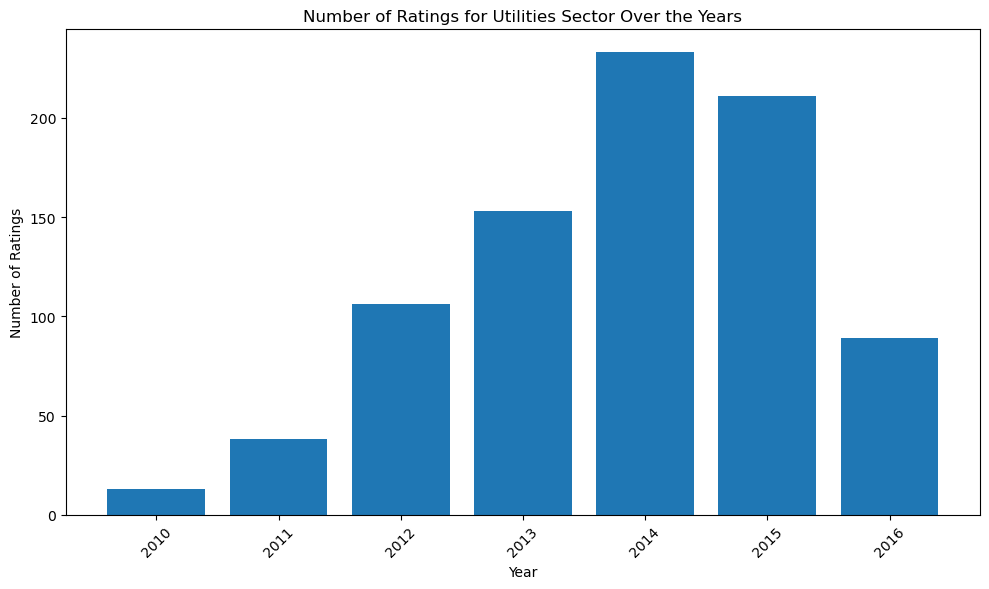

In [7]:
query = """
SELECT YEAR(`Rating Date`) as YEAR, Sector, COUNT(Sector) as SectorCount
FROM ratings
WHERE Sector = 'Utils'
GROUP BY YEAR(`Rating Date`), Sector
ORDER BY YEAR(`Rating Date`);
"""
result_df = spark.sql(query).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(result_df['YEAR'], result_df['SectorCount'])
plt.title('Number of Ratings for Utilities Sector Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

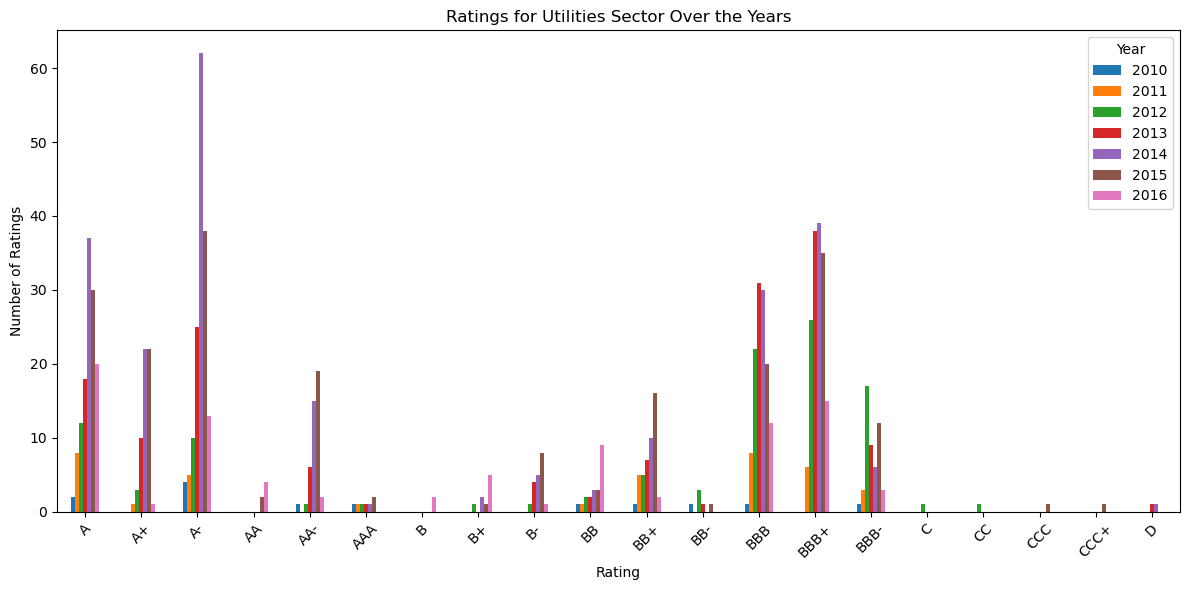

In [8]:
query = """
SELECT YEAR(`Rating Date`) as Year, Rating, COUNT(Rating) as RatingCount
FROM ratings
WHERE Sector = 'Utils'
GROUP BY YEAR(`Rating Date`), Rating
ORDER BY Year;
"""
result_df = spark.sql(query).toPandas()
# result_df.head()

pivot_df = result_df.pivot(index='Rating', columns='Year', values='RatingCount')

# Plotting
pivot_df.plot(kind='bar', figsize=(12, 6))
plt.title('Ratings for Utilities Sector Over the Years')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

In [9]:
query = """
SELECT Rating, COUNT(*) as RatingCount
FROM ratings
GROUP BY Rating
ORDER BY RatingCount DESC
"""
spark.sql(query).show(500)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|   BBB|        910|
|  BBB+|        846|
|     A|        836|
|    A-|        722|
|  BBB-|        705|
|   BB+|        545|
|    A+|        478|
|    BB|        453|
|   BB-|        427|
|    B+|        422|
|     B|        310|
|    B-|        288|
|   AA-|        254|
|    AA|        185|
|  CCC+|        151|
|   AAA|         90|
|   AA+|         73|
|   CCC|         65|
|    CC|         18|
|     C|         11|
|  CCC-|         10|
|     D|          5|
|   CC+|          1|
+------+-----------+



In [10]:
df.printSchema()


root
 |-- Rating Agency: string (nullable = true)
 |-- Corporation: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rating Date: string (nullable = true)
 |-- CIK: string (nullable = true)
 |-- Binary Rating: string (nullable = true)
 |-- SIC Code: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Current Ratio: string (nullable = true)
 |-- Long-term Debt / Capital: string (nullable = true)
 |-- Debt/Equity Ratio: string (nullable = true)
 |-- Gross Margin: string (nullable = true)
 |-- Operating Margin: string (nullable = true)
 |-- EBIT Margin: string (nullable = true)
 |-- EBITDA Margin: string (nullable = true)
 |-- Pre-Tax Profit Margin: string (nullable = true)
 |-- Net Profit Margin: string (nullable = true)
 |-- Asset Turnover: string (nullable = true)
 |-- ROE - Return On Equity: string (nullable = true)
 |-- Return On Tangible Equity: string (nullable = true)
 |-- ROA - Return On Assets: string (null

In [20]:

# Ratings when the Binary Rating = 0
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '0' 
GROUP BY Rating;
"""
spark.sql(query).show(500)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|   CCC|         65|
|     B|        310|
|  CCC+|        151|
|     D|          5|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|    B+|        422|
|    B-|        288|
|  CCC-|         10|
|   BB+|        545|
|   BB-|        427|
|    BB|        453|
+------+-----------+



In [21]:
# Ratings when the Binary Rating = 1
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '1' 
GROUP BY Rating;
"""
spark.sql(query).show(500)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|    AA|        185|
|  BBB+|        846|
|   BBB|        910|
|   AA-|        254|
|   AA+|         73|
|    A-|        722|
|     A|        836|
|    A+|        478|
|  BBB-|        705|
|   AAA|         90|
+------+-----------+



In [26]:
# Average Values for "Good Credit"
query = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '1';
"""
spark.sql(query).show(500)



+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|   CurrentRatioAvg|     DebtCapitalAvg|    DebtEquityAvg|   GrossMarginAvg|OperatingMarginAvg|     EBITMarginAvg|  EBITDAMarginAvg|PreTaxProfitMarginAvg|NetProfitMarginAvg|  AssetTurnoverAvg|            ROEAvg|          ROTEAvg|           ROAAvg|            ROIAvg|       CashFlowAvg|    FreeCashFlowAvg|
+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|1.7000416172505781|0.39154163572461703|0.571551497270132|45.04492034338624|15.263

24/03/18 12:43:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [27]:
# Average Values for "Good Credit"
query = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '0';
"""
spark.sql(query).show(500)


+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+---------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+
|   CurrentRatioAvg|    DebtCapitalAvg|      DebtEquityAvg|    GrossMarginAvg|OperatingMarginAvg|    EBITMarginAvg|   EBITDAMarginAvg|PreTaxProfitMarginAvg| NetProfitMarginAvg|  AssetTurnoverAvg|           ROEAvg|           ROTEAvg|            ROAAvg|            ROIAvg|        CashFlowAvg|    FreeCashFlowAvg|
+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+---------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+
|2.3526830720300156|0.5682417183037755|-0.5654602079360223|37.51389

## Save to a database

In [28]:
# Create a database
conn = sqlite3.connect('../data/db.sqlite')
conn.close()

# Connect to the database
conn = sqlite3.connect('../data/db.sqlite')

# Import CSV into database
df = pd.read_csv('../data/ratings.csv')

df.to_sql('ratings', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})

conn.close()

In [29]:
df.head()

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [30]:
df.columns

Index(['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK',
       'Binary Rating', 'SIC Code', 'Sector', 'Ticker', 'Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object')

## Graphing Distribution

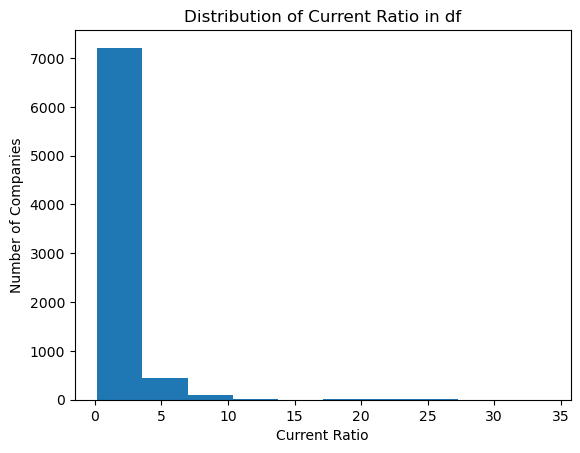

In [32]:
plt.hist(df['Current Ratio'])

plt.xlabel('Current Ratio')
plt.ylabel('Number of Companies')
plt.title('Distribution of Current Ratio in df')

plt.show()

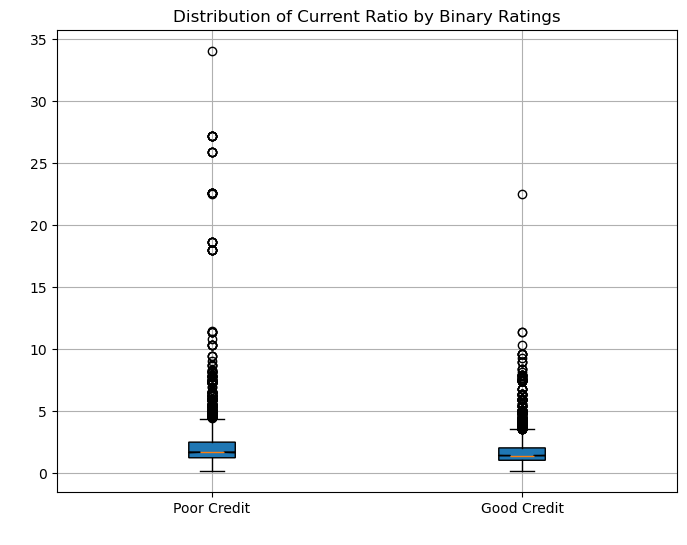

In [40]:
df_rating_0 = df[df['Binary Rating'] == 0]
df_rating_1 = df[df['Binary Rating'] == 1]

plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['Current Ratio'], df_rating_1['Current Ratio']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Current Ratio by Binary Ratings')
plt.grid(True)

plt.show()

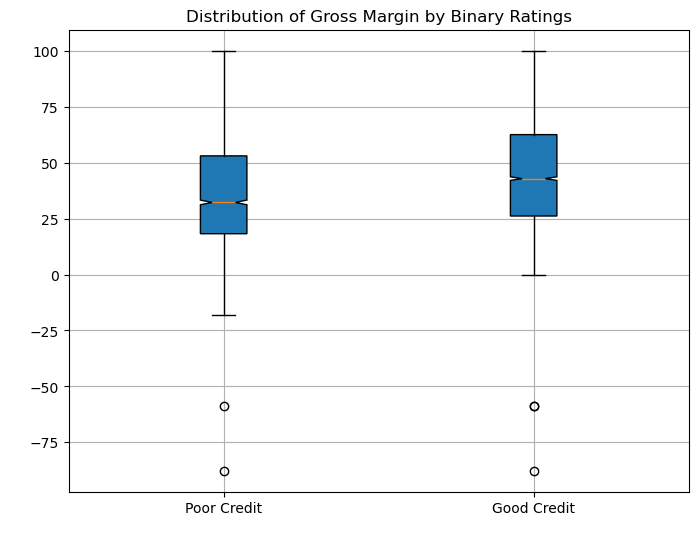

In [41]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['Gross Margin'], df_rating_1['Gross Margin']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Gross Margin by Binary Ratings')
plt.grid(True)

plt.show()

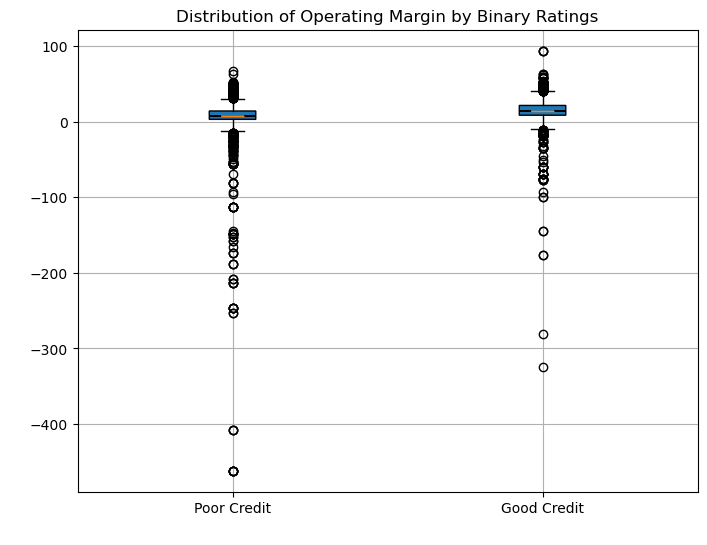

In [37]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['Operating Margin'], df_rating_1['Operating Margin']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Operating Margin by Binary Ratings')
plt.grid(True)

plt.show()

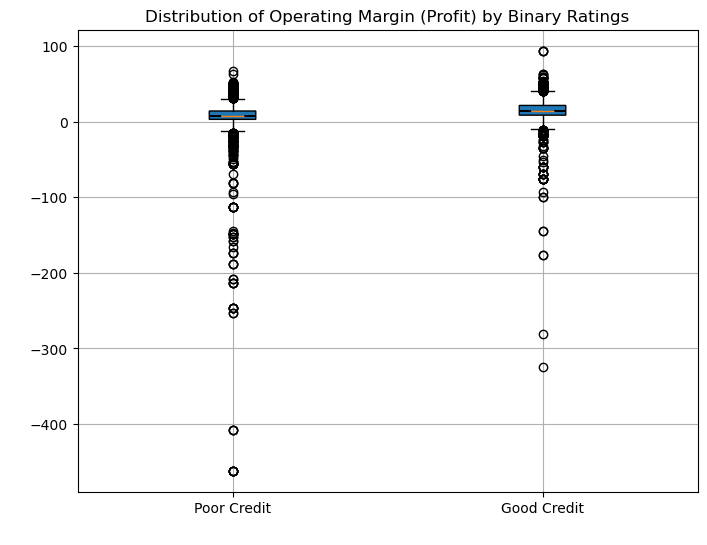

In [43]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['EBIT Margin'], df_rating_1['EBIT Margin']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Operating Margin (Profit) by Binary Ratings')
plt.grid(True)

plt.show()

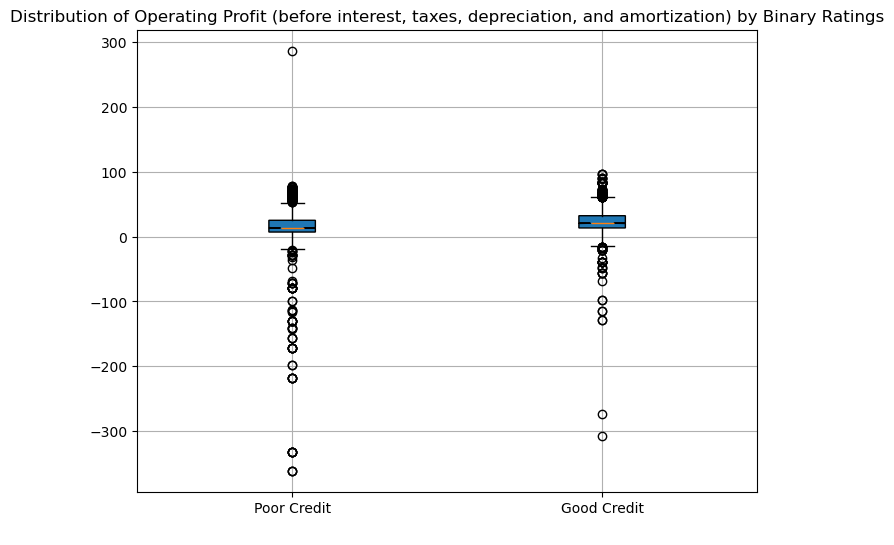

In [44]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['EBITDA Margin'], df_rating_1['EBITDA Margin']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Operating Profit (before interest, taxes, depreciation, and amortization) by Binary Ratings')
plt.grid(True)

plt.show()

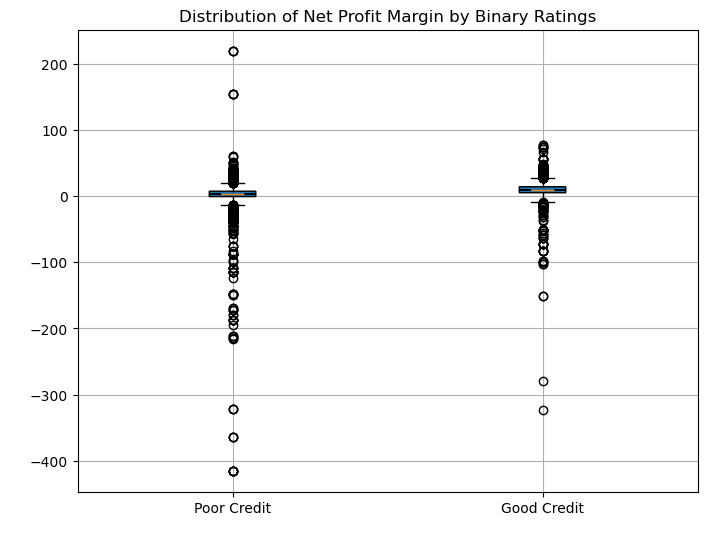

In [45]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['Net Profit Margin'], df_rating_1['Net Profit Margin']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Net Profit Margin by Binary Ratings')
plt.grid(True)

plt.show()

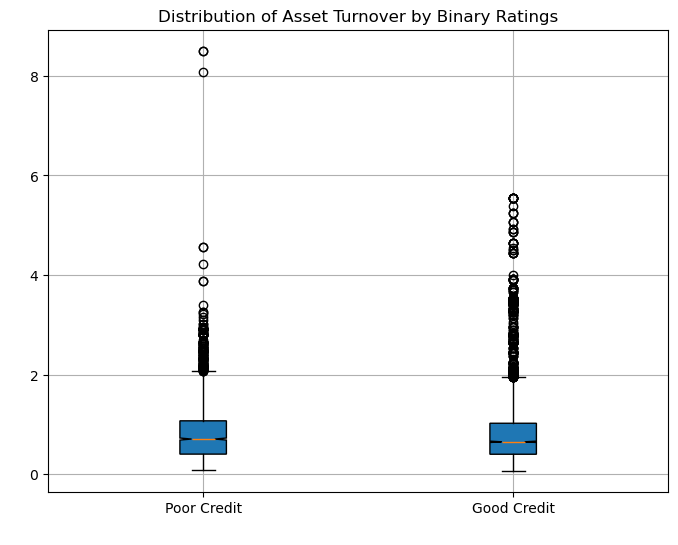

In [46]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['Asset Turnover'], df_rating_1['Asset Turnover']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Asset Turnover by Binary Ratings')
plt.grid(True)

plt.show()

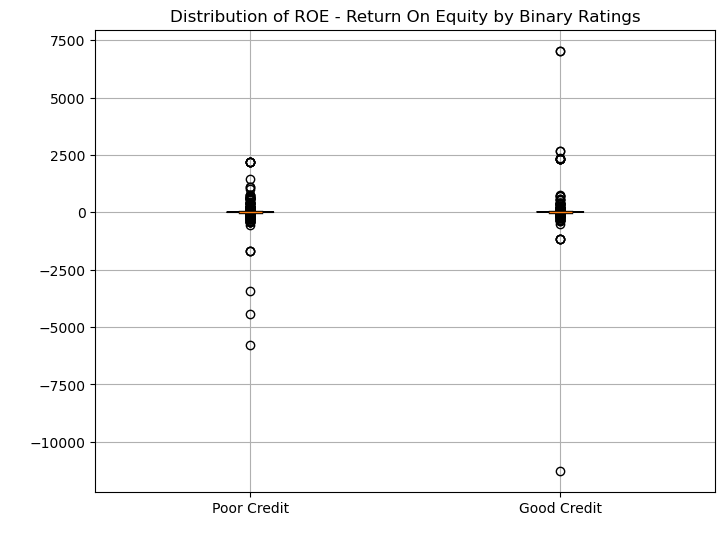

In [47]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['ROE - Return On Equity'], df_rating_1['ROE - Return On Equity']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of ROE - Return On Equity by Binary Ratings')
plt.grid(True)

plt.show()

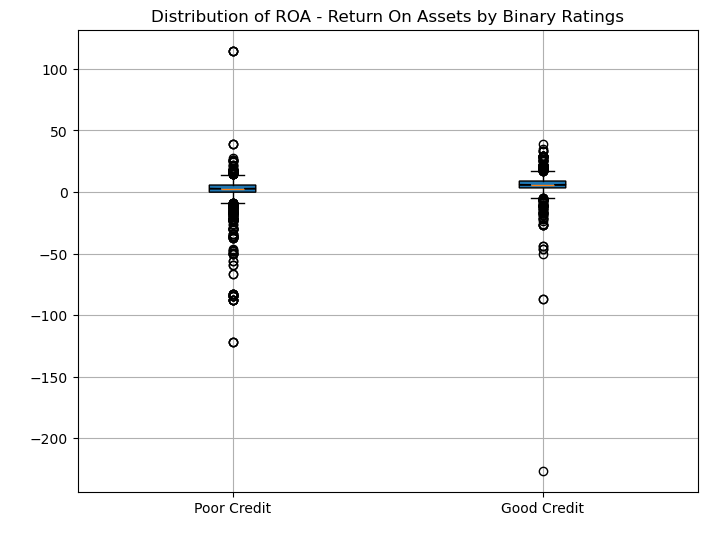

In [48]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['ROA - Return On Assets'], df_rating_1['ROA - Return On Assets']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of ROA - Return On Assets by Binary Ratings')
plt.grid(True)

plt.show()

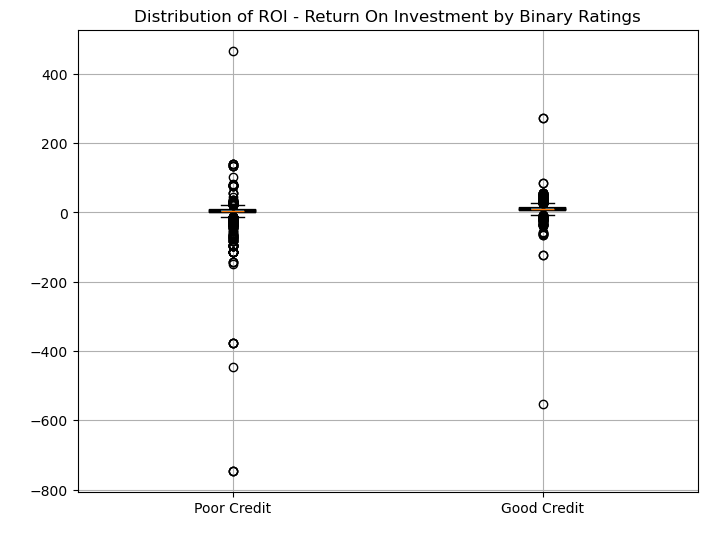

In [49]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['ROI - Return On Investment'], df_rating_1['ROI - Return On Investment']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of ROI - Return On Investment by Binary Ratings')
plt.grid(True)

plt.show()

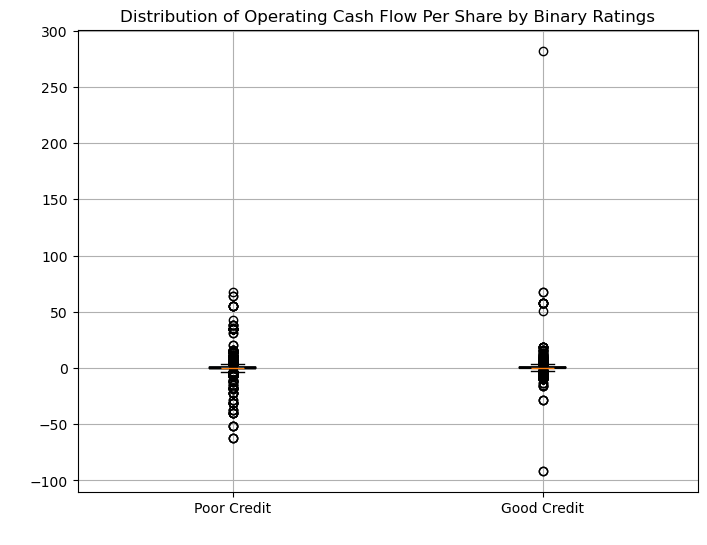

In [50]:
plt.figure(figsize=(8, 6)) 
plt.boxplot([df_rating_0['Operating Cash Flow Per Share'], df_rating_1['Operating Cash Flow Per Share']],
             notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribution of Operating Cash Flow Per Share by Binary Ratings')
plt.grid(True)

plt.show()